In [1]:
from astropy.table import Table, column
import numpy as np
import os

% matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import urllib

#### Code for making the Galaxy Zoo images for the classroom based activity

List of classes:

- Ellipticals (face-on)
- Ellipticals (edge-on)
- Edge-on discs
- Spirals (barred)
- Spirals (two-arm)
- Spirals (many-arm)
- Mergers/interactions

In [2]:
gz2_data = Table.read('fits/full_sample_debiased_w_low_z_mod.fits')

low_z_mask = gz2_data['REDSHIFT_1'] <= 0.04

In [3]:
N_images = 1000

class_names = ['elliptical_face_on','elliptical_edge_on','disc_edge_on',
               'spiral_barred','spiral_two_arm','spiral_many_arm','merger']

class_ratios = [0.1,0.1,0.2,0.2,0.2,0.1,0.1]
class_ratio_total = np.sum(class_ratios)

N_classes = len(class_names)
N_per_class = []

for c in range(N_classes):
    class_ratios[c] /= class_ratio_total
    N_per_class.append(int(N_images * class_ratios[c]))

    
mask0 = (gz2_data['t01_smooth_or_features_a01_smooth_debiased_rh']
       * gz2_data['t07_rounded_a16_completely_round_debiased_rh']
       * low_z_mask) >= 0.75

mask1 = (gz2_data['t01_smooth_or_features_a01_smooth_debiased_rh']
       * gz2_data['t07_rounded_a18_cigar_shaped_debiased_rh']
       * low_z_mask) >= 0.75

mask2 = (gz2_data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
       * gz2_data['t02_edgeon_a04_yes_debiased_rh']
       * low_z_mask) >= 0.75

mask3 = (gz2_data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
       * gz2_data['t02_edgeon_a05_no_debiased_rh']
       * gz2_data['t03_bar_a06_bar_debiased_rh']
       * low_z_mask) >= 0.75

mask4 = (gz2_data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
       * gz2_data['t02_edgeon_a05_no_debiased_rh']
       * gz2_data['t11_arms_number_a32_2_debiased_rh']
       * low_z_mask) >= 0.75

mask5 = (gz2_data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
       * gz2_data['t02_edgeon_a05_no_debiased_rh']
       * (1 - gz2_data['t11_arms_number_a32_2_debiased_rh_normalised'])
       * low_z_mask) >= 0.75

mask6 = (gz2_data['t06_odd_a14_yes_debiased_rh']
       * gz2_data['t08_odd_feature_a24_merger_debiased_rh']) >= 0.75

masks = [mask0,mask1,mask2,mask3,mask4,mask5,mask6]

classes = {}
for name, N, mask in zip(class_names,N_per_class,masks):
    classes[name] = {'N' : N, 'mask' : mask}
    

/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: invalid value encountered in greater_equal
/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: invalid value encountered in greater_equal
/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:37: RuntimeWarning: invalid value encountered in greater_equal
/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater_equal
/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:45: RuntimeWarning: invalid value encountered in greater_equal


In [4]:
np.random.seed(0)

file_directory = 'images/'
os.mkdir(file_directory) if os.path.isdir(file_directory) is False else None

for name in classes.keys():
    class_path = file_directory + name
    os.mkdir(class_path) if os.path.isdir(class_path) is False else None
    
    N_required = classes[name]['N']
    mask = classes[name]['mask']
    N_masked = mask.sum()
    
    masked_table = gz2_data[mask]
    selected_rows = np.random.choice(range(N_masked),N_required,replace=False)
    urls = masked_table['jpeg_url'][selected_rows]
    ids = masked_table['dr7objid'][selected_rows]
    classes[name].update({'ids':np.array(ids)})
    classes[name].update({'urls':np.array(urls)})

In [8]:
def make_image(url,sdss_id,filesave=None,dpi=300):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_axes([0, 0, 1, 1])
    urllib.request.urlretrieve(url,"image.jpg")
    # Open -> crop -> display -> remove the image.
    im=Image.open("image.jpg")
    l=424 # Image size
    crop_in = int(np.round((1/6) * 424,0))
    im=im.crop((0,crop_in,l,l-crop_in))
    ax.imshow(im)
    os.remove("image.jpg")
    ax.set_xticks([])
    ax.set_yticks([])
    
    gz_ax = fig.add_axes([0.76,0.07,0.2,0.1])
    gz_ax.patch.set_visible(False)
    gz_ax.axis('off')
    im = plt.imread('images/gz_logo.png')
    gz_ax.imshow(im)
    ax.text(0.86,0.05,'www.galaxyzoo.org',color='w',
            fontsize=15,transform=ax.transAxes,ha='center')
    
    sdss_ax = fig.add_axes([0.05,0.06,0.18,0.1])
    sdss_ax.patch.set_visible(False)
    sdss_ax.axis('off')
    im = plt.imread('images/sdss_logo.png')
    sdss_ax.imshow(im)
    ax.text(0.13,0.05,id_,color='w',fontsize=10,transform=ax.transAxes)
    
    notts_ax = fig.add_axes([0.75,0.85,0.2,0.1])
    notts_ax.patch.set_visible(False)
    notts_ax.axis('off')
    im = plt.imread('images/nottingham_logo.png')
    notts_ax.imshow(im)
    
    if filesave is not None:
        fig.savefig(filesave,dpi=dpi)
    
    return fig, ax

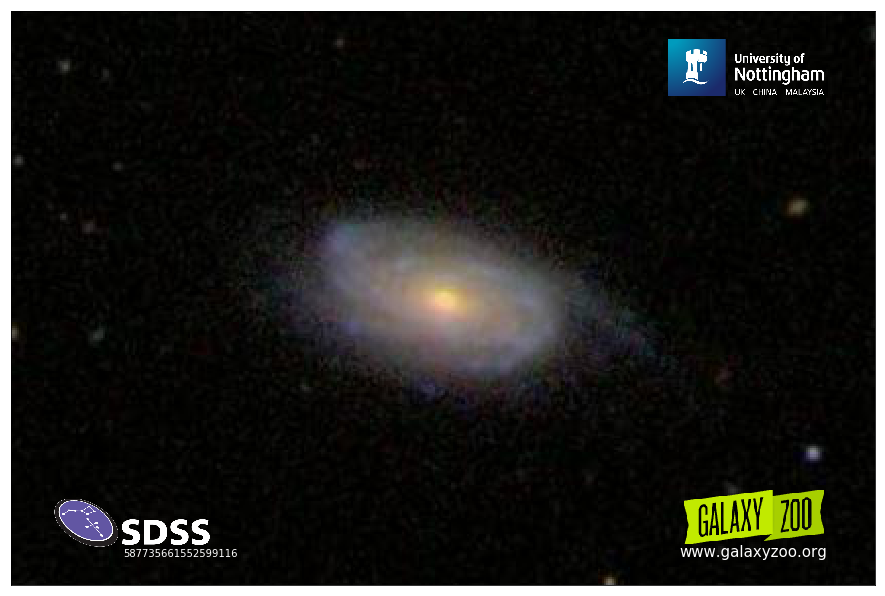

In [6]:
class_ = 'spiral_many_arm'
url = classes[class_]['urls'][0]
id_ = classes[class_]['ids'][0]
_ = make_image(url,id_,'example.jpg')

In [13]:
#for class_ in classes.keys():
    #url = classes[class_]['urls'][0]
    #id_ = classes[class_]['ids'][0]
    #_ = make_image(url,id_,'example_{}.jpg'.format(class_))
    
for class_ in classes.keys():
    os.mkdir(class_) if os.path.exists(class_) else None
    for u, (url, id_) in enumerate(zip(classes[class_]['urls'],classes[class_]['ids'])):
        _ = make_image(url,id_,'{}_{}.jpg'.format(class_,u))
        _ = plt.close('all')